In [1]:
import numpy as np
import EI_subspace_RNN
import scipy.stats as stats
import scipy.linalg
from utils import *
from plotting_utils import *
import matplotlib.pyplot as plt
colormap = ['tab:purple','tab:pink','tab:cyan','yellowgreen', 'olive']

# hyperparameters
K = 2
N_e = 100
N_i = N_e
N = N_e + N_i
D = 50
sparsity = 0.25
U = 200
T = 100
N_weights = int (N * N * sparsity)
max_iter=10

# zeta_alpha_beta_gamma_list = [(10**i,1,1,0) for i in list(np.arange(-1,0.5,0.5))]
zeta_alpha_beta_gamma_list = [(1,1,1,0)]

In [2]:
K_values = [1] #[1,2,3,4,5,10,25,40]
j_values = [0,1,2,3]
J_possibility_title = np.array(['normal QR', 'normal', 'normal + co-act', 'uniform'])
num_simulations=30

In [4]:
def load_data(N, K, j_values, num_simulations, parameter='w'):
    data_interest = np.empty((len(j_values), num_simulations), dtype=object)
    for j in range(len(j_values)):
        for simulation in range(num_simulations):
            data_interest[j, simulation] = np.load(f'models/N={N}_K={K}_parameters_simulation_{simulation}_J_possibility_{j_values[j]}.npz', allow_pickle=True)[parameter]
    return data_interest

trueA = load_data(N, K, j_values=[0], num_simulations=num_simulations, parameter='trueA')
loss_W = load_data(N, K, j_values=j_values, num_simulations=num_simulations, parameter='loss_W')
trueA = load_data(N, K, j_values=j_values, num_simulations=num_simulations, parameter='trueA')
initW = load_data(N, K, j_values=j_values, num_simulations=num_simulations, parameter='initW')
J = load_data(N, K, j_values=j_values, num_simulations=num_simulations, parameter='J')
w = load_data(N, K, j_values=j_values, num_simulations=num_simulations, parameter='w')
ll = load_data(N, K, j_values=j_values, num_simulations=num_simulations, parameter='ll')
lossW = load_data(N, K, j_values=j_values, num_simulations=num_simulations, parameter='lossW')
b = load_data(N, K, j_values=j_values, num_simulations=num_simulations, parameter='b')
s = load_data(N, K, j_values=j_values, num_simulations=num_simulations, parameter='s')
mu0 = load_data(N, K, j_values=j_values, num_simulations=num_simulations, parameter='mu0')
Q0 = load_data(N, K, j_values=j_values, num_simulations=num_simulations, parameter='Q0')
C_ = load_data(N, K, j_values=j_values, num_simulations=num_simulations, parameter='C_')
d = load_data(N, K, j_values=j_values, num_simulations=num_simulations, parameter='d')
R = load_data(N, K, j_values=j_values, num_simulations=num_simulations, parameter='R')


# # fit W
# fitW = np.empty((len(j_values), num_simulations), dtype=object)
# v = np.empty((len(j_values), num_simulations), dtype=object)
# for j in j_values:
#     for simulation in range(num_simulations):
#         RNN = EI_subspace_RNN.EI_subspace_RNN(N_e, N_i, sparsity, J[j, simulation], seed=1)

#         fitW[j, simulation] = RNN.build_full_weight_matrix(w[j,simulation])
#         # # generate network activity
#         # v[j, simulation] = RNN.generate_network_activity(U, T, fitW[j,simulation], b[j,simulation].item(), s[j,simulation], mu0[j,simulation], Q0[j,simulation])


        # eigval_PCA, eigvec_PCA = np.linalg.eig(v_concat.T @ v_concat) # eigvec 0 is eigvec[:,0] - columns
        # ones = np.ones((v_concat.shape[1]))
        # idx = np.argsort(eigval_PCA)[::-1]
        # eigval_PCA = eigval_PCA[idx]
        # eigvec_PCA = eigvec_PCA[:,idx]




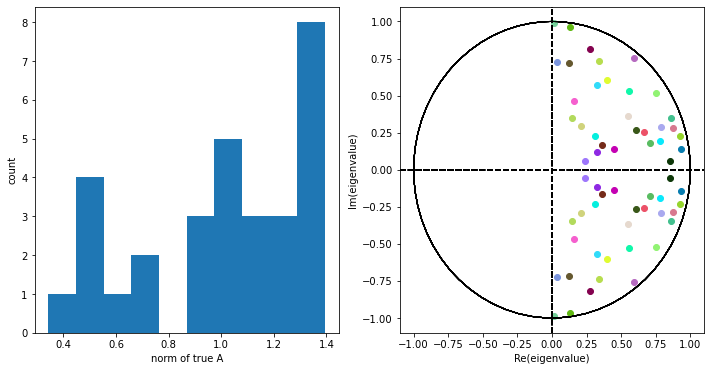

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))
def plot_true_A_norm_eig(axes, trueA, j=0):
    norm_A = np.zeros((trueA.shape[1]))
    for simulation in range(norm_A.shape[0]):
        norm_A[simulation] = np.sqrt(np.trace(trueA[j,simulation].T @ trueA[j,simulation]))
        eigval = np.linalg.eigvals(trueA[j,simulation])
        plot_eigenvalues(axes[1], eigval, color=generate_random_color(), label='')
    axes[0].hist(norm_A, bins=10)
    axes[0].set_xlabel('norm of true A')
    axes[0].set_ylabel('count')

plot_true_A_norm_eig(axes, trueA, j=0)
plt.savefig(f'figures/N={N}_K={K}_figure=0_plot_true_A_norm_eig', bbox_inches='tight', dpi=300)
    

In [6]:

# PLOT NORMALITY OF A here

# fig, axes = plt.subplots(figsize=(8,8))
# for eig in range(3):
#     for simulation in range(30):
#         _, eigvec = np.linalg.eig(trueA[eig,simulation])
#         axes.scatter(eig, angle_vectors(eigvec[:,0], eigvec[:,1]), color='tab:pink')
#         axes.scatter(eig, angle_vectors(eigvec[:,0], eigvec[:,2]), color='tab:orange')
#         axes.scatter(eig, angle_vectors(eigvec[:,1], eigvec[:,2]), color='black')

# axes.scatter(eig, angle_vectors(eigvec[:,0], eigvec[:,1]), color='tab:pink', label='angle (eig1, eig2)')
# axes.scatter(eig, angle_vectors(eigvec[:,0], eigvec[:,2]), color='tab:orange', label='angle (eig1, eig3)')
# axes.scatter(eig, angle_vectors(eigvec[:,1], eigvec[:,2]), color='black', label='angle (eig2, eig3)')
# axes.set_ylabel('angles between eigenvectors')
# axes.set_ylim(0,180)
# axes.set_xlabel('eigenvalues set')
# axes.axhline(90, color='black', linestyle='dashed')
# axes.legend()
# axes.set_xticks(range(10),range(1,11))


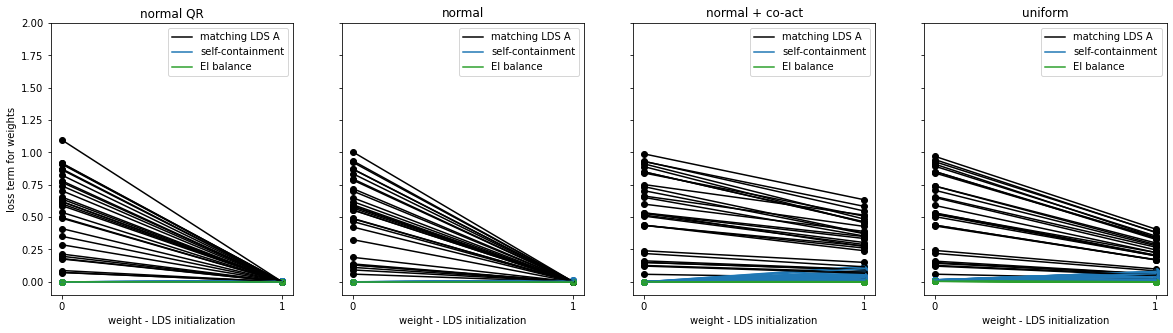

In [7]:
fig, axes = plt.subplots(1, len(j_values), figsize=(5 * len(j_values),5), sharey=True)
def plot_initialization_loss(axes, loss_W, j_values, zeta_alpha_beta_gamma_list):
    j_count = 0
    for j in j_values:

        for simulation in range(loss_W.shape[1]):
            if simulation == 0:
                axes[j_count].plot(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[j,simulation][:,0], color='black', label='matching LDS A')
                axes[j_count].scatter(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[j,simulation][:,0], color='black')
                axes[j_count].plot(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[j,simulation][:,1], color='tab:blue', label='self-containment')
                axes[j_count].scatter(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[j,simulation][:,1], color='tab:blue')
                axes[j_count].plot(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[j,simulation][:,2], color='tab:green', label='EI balance')
                axes[j_count].scatter(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[j,simulation][:,2], color='tab:green')
            else:
                axes[j_count].plot(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[j,simulation][:,0], color='black')
                axes[j_count].scatter(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[j,simulation][:,0], color='black')
                axes[j_count].plot(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[j,simulation][:,1], color='tab:blue')
                axes[j_count].scatter(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[j,simulation][:,1], color='tab:blue')
                axes[j_count].plot(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[j,simulation][:,2], color='tab:green')
                axes[j_count].scatter(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[j,simulation][:,2], color='tab:green')

            axes[j_count].set_xlabel('weight - LDS initialization')
            axes[j_count].set_xticks(range(loss_W[j,simulation][:,0].shape[0]),range(loss_W[j,simulation][:,0].shape[0]))
            axes[j_count].legend(loc='upper right')
            axes[j_count].set_title(f'J variation {j}')
            axes[j_count].set_title(J_possibility_title[j])

        j_count += 1
        axes[0].set_ylabel('loss term for weights')
        axes[0].set_ylim(-0.1,2)

plot_initialization_loss(axes, loss_W, j_values=j_values, zeta_alpha_beta_gamma_list = zeta_alpha_beta_gamma_list)
plt.savefig(f'figures/N={N}_K={K}_figure=1_plot_plot_initialization_loss', bbox_inches='tight', dpi=300)



/Users/lencacuturela/opt/anaconda3/lib/python3.9/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


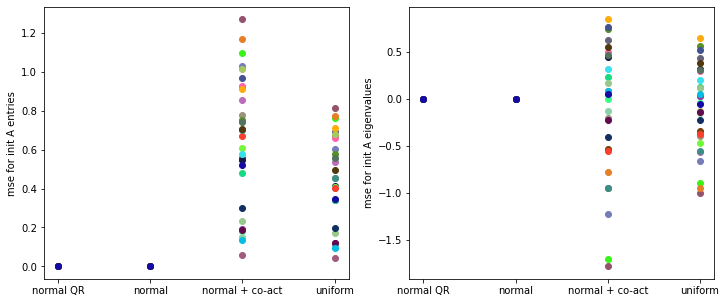

In [9]:
fig, axes = plt.subplots(1,2, figsize=(12, 5))

def plot_dynamics_initialization_error(axes, trueA, initW, j_values=[0,1]):
    for simulation in range(trueA.shape[1]):
        color = generate_random_color()
        for j in j_values:
            initA = build_dynamics_matrix_A(initW[j, simulation], J[j, simulation])
            axes[0].scatter(j, mse(initA, trueA[j, simulation]), color=color)
            axes[1].scatter(j, mse(np.linalg.eigvals(initA).reshape(1,initA.shape[0]), np.linalg.eigvals(trueA[j,simulation]).reshape(1,initA.shape[0])), color=color)

            axes[0].set_xticks(j_values, J_possibility_title[j_values])
            axes[1].set_xticks(j_values, J_possibility_title[j_values])
       
        axes[0].set_ylabel('mse for init A entries')
        axes[1].set_ylabel('mse for init A eigenvalues')

plot_dynamics_initialization_error(axes, trueA, initW, j_values=j_values)
plt.savefig(f'figures/N={N}_K={K}_figure=2_plot_dynamics_initialization_error', bbox_inches='tight', dpi=300)


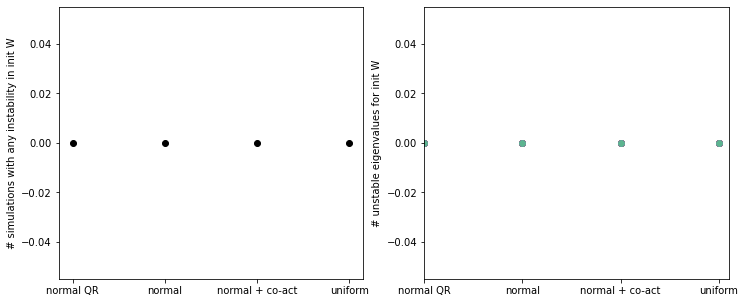

In [46]:
fig, axes = plt.subplots(1,2, figsize=(12, 5))

initW = load_data(N, K, j_values=j_values, num_simulations=num_simulations, parameter='initW')

def plot_unstable_initializations(axes, initW, j_values=[0,1]):
    binary_unstable_init = np.zeros((len(j_values), 30))
    count_unstable_init = np.zeros((4, 30))

    for simulation in range(trueA.shape[1]):
        color = generate_random_color()
        for j in j_values:
            eig_init = np.linalg.eigvals(initW[j,simulation]) 
            eig_norms = norm_complex_scalar(eig_init)

            if len(np.argwhere(eig_norms > 1)) > 0:
                binary_unstable_init[j, simulation] = 1
                count_unstable_init[j, simulation] = len(np.argwhere(eig_norms > 1))
            
            axes[1].scatter(j, count_unstable_init[j, simulation], color=color)


    axes[0].scatter(j_values, binary_unstable_init.sum(axis=1), color='black')
    axes[0].set_xticks(j_values, J_possibility_title[j_values])
    axes[1].set_xticks(j_values, J_possibility_title[j_values])
    axes[0].set_ylabel('# simulations with any instability in init W')
    axes[1].set_ylabel('# unstable eigenvalues for init W')

plot_unstable_initializations(axes, initW, j_values=j_values)
plt.savefig(f'figures/N={N}_K={K}_figure=3_plot_unstable_initializations', bbox_inches='tight', dpi=300)





In [47]:
# # whether instability in fitting is solely caused by instability in initialization

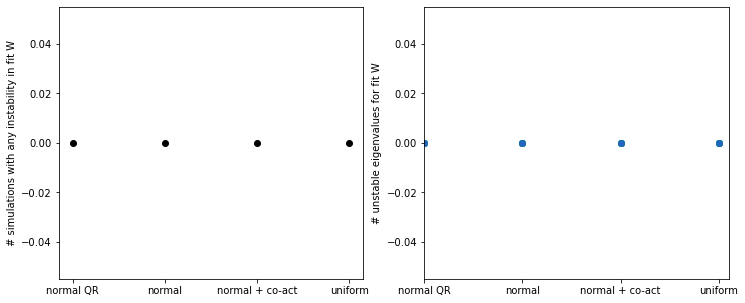

In [48]:
fig, axes = plt.subplots(1,2, figsize=(12, 5))
def plot_unstable_fitting(axes, fitW, j_values=[0,1]):
    binary_unstable_init = np.zeros((len(j_values), 30))
    count_unstable_init = np.zeros((4, 30))

    for simulation in range(trueA.shape[1]):
        color = generate_random_color()
        for j in j_values:
            eig_init = np.linalg.eigvals(fitW[j,simulation]) 
            eig_norms = norm_complex_scalar(eig_init)

            if len(np.argwhere(eig_norms > 1)) > 0:
                binary_unstable_init[j, simulation] = 1
                count_unstable_init[j, simulation] = len(np.argwhere(eig_norms > 1))
            
            axes[1].scatter(j, count_unstable_init[j, simulation], color=color)

    axes[0].scatter(j_values, binary_unstable_init.sum(axis=1), color='black')
    axes[0].set_xticks(j_values, J_possibility_title[j_values])
    axes[1].set_xticks(j_values, J_possibility_title[j_values])
    axes[0].set_ylabel('# simulations with any instability in fit W')
    axes[1].set_ylabel('# unstable eigenvalues for fit W')

plot_unstable_fitting(axes, fitW, j_values=j_values)
plt.savefig(f'figures/N={N}_K={K}_figure=4_plot_unstable_fitting', bbox_inches='tight', dpi=300)


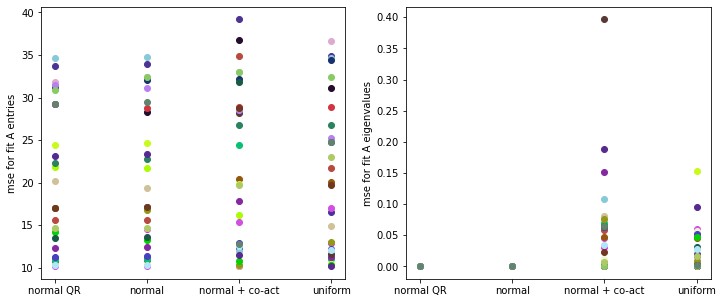

In [52]:
fig, axes = plt.subplots(1,2, figsize=(12, 5))
def plot_fit_dynamics_error(axes, trueA, fitW, j_values=[0,1]):
    for simulation in range(trueA.shape[1]):
        color = generate_random_color()
        for j in j_values:
            fitA = build_dynamics_matrix_A(fitW[j, simulation], J[j, simulation])

            axes[0].scatter(j, mse(fitA, trueA), color=color)
            axes[1].scatter(j, mse(np.linalg.eigvals(fitA).reshape(1,fitA.shape[0]), np.linalg.eigvals(trueA[j,simulation]).reshape(1,fitA.shape[0])), color=color)
            axes[0].set_xticks(j_values, J_possibility_title[j_values])
            axes[1].set_xticks(j_values, J_possibility_title[j_values])
       
        axes[0].set_ylabel('mse for fit A entries')
        axes[1].set_ylabel('mse for fit A eigenvalues')

plot_fit_dynamics_error(axes, trueA, fitW, j_values=j_values)
plt.savefig(f'figures/N={N}_K={K}_figure=5_plot_fit_dynamics_error', bbox_inches='tight', dpi=300)


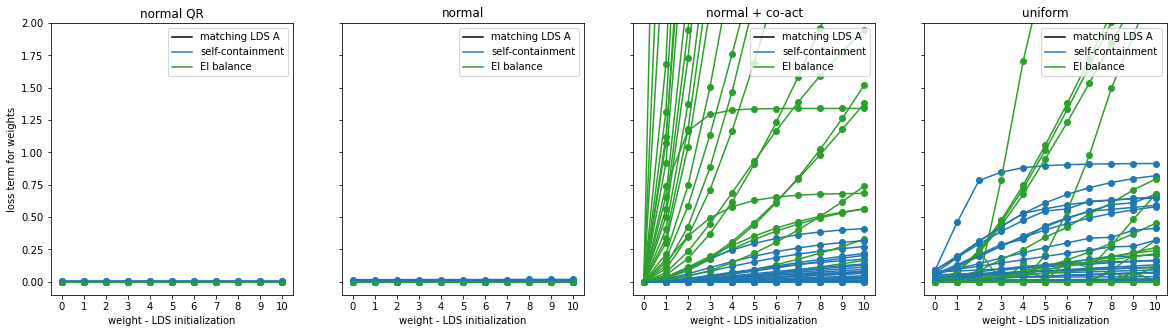

In [53]:
fig, axes = plt.subplots(1, len(j_values), figsize=(5 * len(j_values),5), sharey=True)
lossW = load_data(N, K, j_values=j_values, num_simulations=num_simulations, parameter='lossW')

def plot_fitting_loss(axes, lossW, j_values, zeta_alpha_beta_gamma_list):
    j_count = 0
    for j in j_values:
        for simulation in range(loss_W.shape[1]):
            if simulation == 0:
                axes[j_count].plot(range(max_iter+1), lossW[j,simulation][:,0], color='black', label='matching LDS A')
                axes[j_count].scatter(range(max_iter+1), lossW[j,simulation][:,0], color='black')
                axes[j_count].plot(range(max_iter+1), lossW[j,simulation][:,1], color='tab:blue', label='self-containment')
                axes[j_count].scatter(range(max_iter+1), lossW[j,simulation][:,1], color='tab:blue')
                axes[j_count].plot(range(max_iter+1), lossW[j,simulation][:,2], color='tab:green', label='EI balance')
                axes[j_count].scatter(range(max_iter+1), lossW[j,simulation][:,2], color='tab:green')
            else:
                axes[j_count].plot(range(max_iter+1), lossW[j,simulation][:,0], color='black')
                axes[j_count].scatter(range(max_iter+1), lossW[j,simulation][:,0], color='black')
                axes[j_count].plot(range(max_iter+1), lossW[j,simulation][:,1], color='tab:blue')
                axes[j_count].scatter(range(max_iter+1), lossW[j,simulation][:,1], color='tab:blue')
                axes[j_count].plot(range(max_iter+1), lossW[j,simulation][:,2], color='tab:green')
                axes[j_count].scatter(range(max_iter+1), lossW[j,simulation][:,2], color='tab:green')

            axes[j_count].set_xlabel('weight - LDS initialization')
            axes[j_count].set_xticks(range(lossW[j,simulation][:,0].shape[0]),range(lossW[j,simulation][:,0].shape[0]))
            axes[j_count].legend(loc='upper right')
            axes[j_count].set_title(f'J variation {j}')
            axes[j_count].set_title(J_possibility_title[j])

        j_count += 1
        axes[0].set_ylabel('loss term for weights')
        axes[0].set_ylim(-0.1,2)

plot_fitting_loss(axes, lossW, j_values=j_values, zeta_alpha_beta_gamma_list = zeta_alpha_beta_gamma_list)
plt.savefig(f'figures/N={N}_K={K}_figure=6_plot_fitting_loss', bbox_inches='tight', dpi=300)




In [ ]:
# def plot_error_parameters(b, s, mu0, Q0, C_, d, R):


# b = load_data(N, K, j_values=j_values, num_simulations=num_simulations, parameter='b')
# s = load_data(N, K, j_values=j_values, num_simulations=num_simulations, parameter='s')
# mu0 = load_data(N, K, j_values=j_values, num_simulations=num_simulations, parameter='mu0')
# Q0 = load_data(N, K, j_values=j_values, num_simulations=num_simulations, parameter='Q0')
# C_ = load_data(N, K, j_values=j_values, num_simulations=num_simulations, parameter='C_')
# d = load_data(N, K, j_values=j_values, num_simulations=num_simulations, parameter='d')
# R = load_data(N, K, j_values=j_values, num_simulations=num_simulations, parameter='R')


# for eig in range(3):
#     fig, axes = plt.subplots(figsize=(5,5))
#     for simulation in range(30):
#         if binary_unstable_init[eig, simulation] == 0 and binary_unstable_fit[eig,simulation] == 0: 
#             plot_mse_parameters(axes, b[eig,simulation].item(), s[eig,simulation], mu0[eig,simulation], Q0[eig,simulation], C_[eig,simulation], d[eig,simulation], R[eig,simulation], true_b[eig,simulation].item(), true_s[eig,simulation], true_mu0[eig,simulation], true_Q0[eig,simulation], true_C_[eig,simulation], true_d[eig,simulation], true_R[eig,simulation])

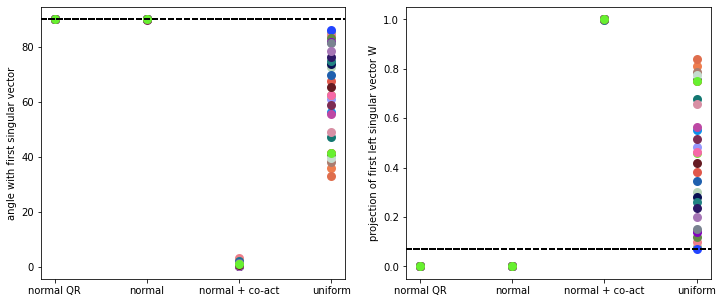

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

def plot_relationship_W_J(axes, fitW, J, j_values=[0,1]):
    for simulation in range(trueA.shape[1]):
        color = generate_random_color()
        for j in j_values:
            # ones = np.ones((J[0,0].shape[1]))
            # v_proj, angle = projection_on_subspace(ones, J[j,simulation])
            # axes[0].scatter(j, np.linalg.norm(v_proj)/np.linalg.norm(ones), color='tab:red', label=f'co-activation', linewidth=3)
            
            U, s, Vh = np.linalg.svd(fitW[j,simulation])
            v_proj, angle = projection_on_subspace(U[:,0],J[j,simulation])
            axes[0].scatter(j, angle, color=color, linewidth=3)
            axes[1].scatter(j, np.linalg.norm(v_proj)/np.linalg.norm(U[:,0]), color=color, linewidth=3)

            axes[0].axhline(90, color='black', linestyle='dashed', label='')
            axes[1].axhline(np.sqrt(K/N), color='black', linestyle='dashed', label='chance = sqrt(K/N)')

        axes[0].set_xticks(j_values, J_possibility_title[j_values])
        axes[1].set_xticks(j_values, J_possibility_title[j_values])
        axes[0].set_ylabel('angle with first singular vector')
        axes[1].set_ylabel('projection of first left singular vector W')

plot_relationship_W_J(axes, fitW, J, j_values=j_values)
plt.savefig(f'figures/N={N}_K={K}_figure=6_plot_relationship_W_J', bbox_inches='tight', dpi=300)


# fig, axes = plt.subplots(figsize=(5,6))
# for k in range(K):
#     v_proj, angle = projection_on_subspace(eigvec_PCA[:,k],J)
#     axes.axhline(np.linalg.norm(v_proj)/np.linalg.norm(eigvec_PCA[:,k]), color=colormap[k], label=f'PCA comp {k+1}', linewidth=3)

# v_proj, angle = projection_on_subspace(ones, J)
# axes.axhline(np.linalg.norm(v_proj)/np.linalg.norm(ones), color='tab:red', label=f'co-activation', linewidth=3)

# v_proj, angle = projection_on_subspace(U[:,0],J)
# axes.axhline(np.linalg.norm(v_proj)/np.linalg.norm(U[:,0]), color='yellow', label=f'first singular vector W', linewidth=3)


# axes.axhline(np.sqrt(K/N), color='black', linestyle='dashed', label='chance = sqrt(K/N)')
# axes.set_ylabel('length of projection on subspace J')
# # axes.set_ylim(0,120)
# axes.set_xticks([],[])
# # axes.set_yticks([0,30,60,90,120],[0,30,60,90,120])
# axes.legend()

In [ ]:

def PCA_cluster():
    eigvec_PCA = 
# PCA on network activity
v_concat = v.reshape(v.shape[0] * v.shape[1], v.shape[2])
y_concat = y.reshape(y.shape[0] * y.shape[1], y.shape[2])
# v_avg = v.mean(axis=0).reshape(v.shape[1], v.shape[2])
# mean = v_avg.mean(axis=0)
mean = v_concat.mean(axis=0)

# mean-center
v_concat = v_concat - mean
# v_mean = v_avg - mean

eigval_PCA, eigvec_PCA = np.linalg.eig(v_concat.T @ v_concat) # eigvec 0 is eigvec[:,0] - columns
ones = np.ones((v_concat.shape[1]))
idx = np.argsort(eigval_PCA)[::-1]
eigval_PCA = eigval_PCA[idx]
eigvec_PCA = eigvec_PCA[:,idx]
# eigval, eigvec = np.linalg.eig(v_mean.T @ v_mean) # eigvec 0 is eigvec[:,0] - columns
# ones = np.ones((v_mean.shape[1]))

# variance explained in PCA
fig, axes = plt.subplots(figsize=(7,5))
var_explained_pc = np.zeros((v_concat.shape[1]))
cumul_var_explained_pc = np.zeros((v_concat.shape[1]))
axes2 = axes.twinx()
for i in range(var_explained_pc.shape[0]):
    var_explained_pc[i] = eigval_PCA[i] / eigval_PCA.sum()
    cumul_var_explained_pc[i] = var_explained_pc[:i+1].sum()
axes.plot(range(25), var_explained_pc[:25], color='black')
axes.scatter(range(25), var_explained_pc[:25], label='individual', color='black')
axes2.plot(range(25), cumul_var_explained_pc[:25], color='gray')
axes2.scatter(range(25), cumul_var_explained_pc[:25], label='cumulative', color='gray')
axes.axhline(0, color='black', linestyle='dashed')
axes.set_ylabel('variance explained')
axes2.set_ylabel('cumulative variance explained')
axes.set_xlabel('PC dimension')
axes.set_xticks([0,1,2,3,4,5,9,14,19,24],[1,2,3,4,5,6,10,15,20,25])
axes2.set_ylim(0,1)
axes.set_title('PCA on network activity')

In [ ]:
# alignment of two subspaces - variance explained in projection (for stable weights)

fraction_cov_var_PCA = np.zeros((10, 30))
fraction_cov_var_J = np.zeros((10, 30))
for eig in range(3):
    for simulation in range(30):
        

        if binary_unstable_init[eig, simulation] == 0 and binary_unstable_fit[eig,simulation] == 0: # both init and fit weights are stable
            RNN = EI_subspace_RNN.EI_subspace_RNN(N_e, N_i, sparsity, J[eig, simulation],  seed=1)
            # print(fitW[eig, simulation].shape)
            # print(mu0[eig, simulation].shape)
            # print(Q0[eig, simulation].shape)
            v = RNN.generate_network_activity(U, T, fitW[eig, simulation], b[eig, simulation].item(), float(s[eig, simulation]), mu0[eig, simulation], Q0[eig, simulation])

            # PCA on data
            v_concat = v.reshape(v.shape[0] * v.shape[1], v.shape[2])
            # v_avg = v.mean(axis=0).reshape(v.shape[1], v.shape[2])
            # mean = v_avg.mean(axis=0)
            mean = v_concat.mean(axis=0)

            # mean-center
            v_concat = v_concat - mean
            # v_mean = v_avg - mean

            eigval_PCA, eigvec_PCA = np.linalg.eig(v_concat.T @ v_concat) # eigvec 0 is eigvec[:,0] - columns
            ones = np.ones((v_concat.shape[1]))
            # eigval, eigvec = np.linalg.eig(v_mean.T @ v_mean) # eigvec 0 is eigvec[:,0] - columns
            # ones = np.ones((v_mean.shape[1]))
            idx = np.argsort(eigval_PCA)[::-1]
            eigval_PCA = eigval_PCA[idx]
            eigvec_PCA = eigvec_PCA[:,idx]

            dim_PCA = 3

            fraction_cov_var_J[eig, simulation], fraction_cov_var_PCA[eig,simulation] = covariance_alignment(v_concat, J[eig,simulation], eigvec_PCA[:,:dim_PCA])

            # # variance explained in PCA
            # fig, axes = plt.subplots(figsize=(7,5))
            # var_explained_pc = np.zeros((v_concat.shape[1]))
            # cumul_var_explained_pc = np.zeros((v_concat.shape[1]))
            # axes2 = axes.twinx()
            # for i in range(var_explained_pc.shape[0]):
            #     var_explained_pc[i] = eigval_PCA[i] / eigval_PCA.sum()
            #     cumul_var_explained_pc[i] = var_explained_pc[:i+1].sum()
            # axes.plot(range(10), var_explained_pc[:10], color='black')
            # axes.scatter(range(10), var_explained_pc[:10], label='individual', color='black')
            # axes2.plot(range(10), cumul_var_explained_pc[:10], color='gray')
            # axes2.scatter(range(10), cumul_var_explained_pc[:10], label='cumulative', color='gray')
            # axes.axhline(0, color='black', linestyle='dashed')
            # axes.set_ylabel('variance explained')
            # axes2.set_ylabel('cumulative variance explained')
            # axes.set_xlabel('PC dimension')
            # axes.set_xticks(range(10),range(1,11))
            # axes2.set_ylim(0,1.05)
            # axes.set_title(f'PCA on network - eig set = {eig}')
            

KeyboardInterrupt: 

In [99]:
print(fraction_cov_var_J.shape)
print(fraction_cov_var_PCA.shape)

(10, 30)
()


(0.0, 0.7)

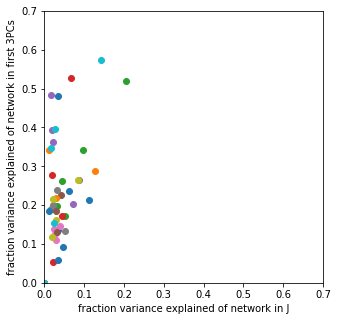

In [108]:
fig, axes = plt.subplots(figsize=(5,5))
for eig in range(10):
    for simulation in range(30):
        axes.scatter(fraction_cov_var_J[eig,simulation],fraction_cov_var_PCA[eig,simulation])
axes.set_xlabel('fraction variance explained of network in J')
axes.set_ylabel('fraction variance explained of network in first 3PCs')
axes.set_xlim(0,0.7)
axes.set_ylim(0,0.7)